# Gene annotation
The original per sample adatas did not contain EIDs (Ensembl IDs, the adatas contained only gene symbols) thus map between gene symbols used across adatas and EIDs (provided by core processing facility separately for each sample (matching within dataset)), since these will differ due to different used genomic versions. Retrieve and save gene symbol to EID and genomic location mapping.

In [1]:
import pandas as pd
import pyensembl
import scanpy as sc
import anndata
from pathlib import Path
from matplotlib import cm
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np

import sys  
sys.path.insert(0, '/lustre/groups/ml01/code/karin.hrovatin/diabetes_analysis/')
from constants import SAVE

INFO:numexpr.utils:Note: NumExpr detected 48 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:get_version:dirname: Trying to get version of get_version from dirname /mnt/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages
INFO:get_version:dirname: Failed; Does not match re.compile('get[_-]version-([\\d.]+?)(?:\\.dev(\\d+))?(?:[_+-]([0-9a-zA-Z.]+))?$')
INFO:get_version:git: Trying to get version from git in directory /mnt/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages
INFO:get_version:git: Failed; directory is not managed by git
INFO:get_version:metadata: Trying to get version for get_version in dir /home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages
INFO:get_version:metadata: Succeeded
INFO:get_version:dirname: Trying to get version of legacy_api_wrap from dirname /mnt/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-

## Ens ids from features file from cellranger 

Map symbols to EIDs for eacdh dataset and subset to genes only/remove reporter transcript features.

In [3]:
features=[]
have_nongenes=set()
nongenes=set()
# File reporting EID files location for each sample
files_data=pd.read_table('/lustre/groups/ml01/workspace/karin.hrovatin//data/pancreas/scRNA/raw_file_list.tsv')
for i,sample in files_data.iterrows():
    has_nongenes=False
    # Load features from cellranger
    ending='features.tsv'
    if sample['ending']=='gene_bc_matrices.h5ad':
        ending='genes.tsv'
    features_f=pd.read_table(sample['dir_cellranger']+ending,header=None)
    features_f.columns=['EID','gene_symbol_adata','feature_type'][:features_f.shape[1]]
    features_f.index=features_f['EID']
    # map gene names to gene names used in adata
    af=anndata.AnnData(var=features_f)
    af.var_names=features_f['gene_symbol_adata']
    af.var_names_make_unique()
    features_f['gene_symbol_adata']=af.var_names
    # load features from adata
    features_used=sc.read(sample['dir']+'filtered_'+sample['ending'],backed='r').var_names
    
    # Keep only features in adata
    features_previous=features_f.index.values
    features_f.index=features_f['gene_symbol_adata']
    features_f=features_f.loc[features_used,:]
    features_f.index=features_f['EID']
    if (features_previous.shape[0]-features_f.shape[0])!=0:
        print('not in adata:',set(features_previous)-set(features_f.index.values),'in',
             sample['study'],sample['sample'])
        
    # keep only genes
    features_previous=features_f.index.values
    if 'feature_type' in features_f.columns:
        # featuyre type NA
        features_f=features_f[~features_f.feature_type.isna()]
        # Feature type not Gene Expression
        features_f=features_f[
            features_f.feature_type=='Gene Expression']
    if (features_previous.shape[0]-features_f.shape[0])!=0:
        print('non-genes:',set(features_previous)-set(features_f.index.values),'in',
             sample['study'],sample['sample'])
        has_nongenes=True
    # index not starting with EID - custom reporter genes added to genome
    features_previous=features_f.index.values
    features_f=features_f[features_f.index.str.startswith('ENSMUSG')]
    if (features_previous.shape[0]-features_f.shape[0])!=0:
        print('non-ENSid:',set(features_previous)-set(features_f.index.values),'in',
              sample['study'],sample['sample'])
        has_nongenes=True
    if has_nongenes:
        have_nongenes.add(sample['study']+'__'+sample['sample'])
    
    # Save features to df
    features_f=features_f['gene_symbol_adata']
    features_f.name=sample['study']+'__'+sample['sample']
    features.append(features_f)
features=pd.concat(features,axis=1)

non-ENSid: {'Td-Tomato-minus', 'eGFP_plus', 'eGFP_minus', 'Td-Tomato-plus'} in Fltp_2y MUC13974
non-ENSid: {'Td-Tomato-minus', 'eGFP_plus', 'eGFP_minus', 'Td-Tomato-plus'} in Fltp_2y MUC13975
non-ENSid: {'Td-Tomato-minus', 'eGFP_plus', 'eGFP_minus', 'Td-Tomato-plus'} in Fltp_2y MUC13976
non-ENSid: {'Td-Tomato-minus', 'eGFP_plus', 'eGFP_minus', 'Td-Tomato-plus'} in Fltp_P16 145_mGFP
non-ENSid: {'Td-Tomato-minus', 'eGFP_plus', 'eGFP_minus', 'Td-Tomato-plus'} in Fltp_P16 146_mRFP
non-ENSid: {'Td-Tomato-minus', 'eGFP_plus', 'eGFP_minus', 'Td-Tomato-plus'} in Fltp_P16 147_mTmG
non-ENSid: {'venus_construct_minus', 'venus_construct_plus'} in Fltp_adult mouse1
non-ENSid: {'venus_construct_minus', 'venus_construct_plus'} in Fltp_adult mouse2
non-ENSid: {'venus_construct_minus', 'venus_construct_plus'} in Fltp_adult mouse4
non-ENSid: {'venus_construct_minus', 'venus_construct_plus'} in Fltp_adult mouse3
non-ENSid: {'ngn3_plus', 'ngn3_minus', 'pdx_minus', 'pdx_plus'} in NOD SRR10985097
non-ENSid:

### Do gene symbols match for EIDs
Which symbols match across data. Namely, there are genes for which symbols do not match or are nan in some samples but annotated in other samples.

In [26]:
# Extract non-matching genes
different_anno=dict()
for row,row_data in features.iterrows():
    if row_data.unique().shape[0]>1:
        different_anno[row]={group:group_data.index 
                                for group,group_data in 
                                row_data.fillna('NA').groupby(row_data.fillna('NA'))}
# Per-sample view of non-matching genes
features.loc[different_anno.keys(),:]

,Fltp_2y__MUC13974,Fltp_2y__MUC13975,Fltp_2y__MUC13976,Fltp_P16__145_mGFP,Fltp_P16__146_mRFP,Fltp_P16__147_mTmG,Fltp_adult__mouse1,Fltp_adult__mouse2,Fltp_adult__mouse4,Fltp_adult__mouse3,...,spikein_drug__SRR10751507,spikein_drug__SRR10751508,spikein_drug__SRR10751509,spikein_drug__SRR10751510,spikein_drug__SRR10751511,spikein_drug__SRR10751512,spikein_drug__SRR10751513,spikein_drug__SRR10751514,spikein_drug__SRR10751515,spikein_drug__SRR10751516
ENSMUSG00000097109,Gm26580,Gm26580,Gm26580,Gm26580,Gm26580,Gm26580,Gm26580,Gm26580,Gm26580,Gm26580,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSMUSG00000073730,4933415F23Rik,4933415F23Rik,4933415F23Rik,4933415F23Rik,4933415F23Rik,4933415F23Rik,4933415F23Rik,4933415F23Rik,4933415F23Rik,4933415F23Rik,...,Ppp1r14bl,Ppp1r14bl,Ppp1r14bl,Ppp1r14bl,Ppp1r14bl,Ppp1r14bl,Ppp1r14bl,Ppp1r14bl,Ppp1r14bl,Ppp1r14bl
ENSMUSG00000026064,Ptp4a1,Ptp4a1,Ptp4a1,Ptp4a1,Ptp4a1,Ptp4a1,Ptp4a1,Ptp4a1,Ptp4a1,Ptp4a1,...,Ptp4a1-1,Ptp4a1-1,Ptp4a1-1,Ptp4a1-1,Ptp4a1-1,Ptp4a1-1,Ptp4a1-1,Ptp4a1-1,Ptp4a1-1,Ptp4a1-1
ENSMUSG00000117310,Ptp4a1-1,Ptp4a1-1,Ptp4a1-1,Ptp4a1-1,Ptp4a1-1,Ptp4a1-1,Ptp4a1-1,Ptp4a1-1,Ptp4a1-1,Ptp4a1-1,...,Ptp4a1,Ptp4a1,Ptp4a1,Ptp4a1,Ptp4a1,Ptp4a1,Ptp4a1,Ptp4a1,Ptp4a1,Ptp4a1
ENSMUSG00000117091,AC153137.1,AC153137.1,AC153137.1,AC153137.1,AC153137.1,AC153137.1,AC153137.1,AC153137.1,AC153137.1,AC153137.1,...,Gm5698,Gm5698,Gm5698,Gm5698,Gm5698,Gm5698,Gm5698,Gm5698,Gm5698,Gm5698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000117871,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Gm50287,Gm50287,Gm50287,Gm50287,Gm50287,Gm50287,Gm50287,Gm50287,Gm50287,Gm50287
ENSMUSG00000118223,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1810035K13Rik,1810035K13Rik,1810035K13Rik,1810035K13Rik,1810035K13Rik,1810035K13Rik,1810035K13Rik,1810035K13Rik,1810035K13Rik,1810035K13Rik
ENSMUSG00000118031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Gm19956,Gm19956,Gm19956,Gm19956,Gm19956,Gm19956,Gm19956,Gm19956,Gm19956,Gm19956
ENSMUSG00000118190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Gm50411,Gm50411,Gm50411,Gm50411,Gm50411,Gm50411,Gm50411,Gm50411,Gm50411,Gm50411


Genes for which symbols do not match (exluding those that are nan in some samples but not others)

In [11]:
different_symbol=dict()
for row,row_data in features.iterrows():
    if row_data.nunique(dropna=True)>1:
        different_symbol[row]={group:group_data.index 
                                for group,group_data in 
                                row_data.groupby(row_data)}
features.loc[different_symbol.keys(),:]

,Fltp_2y__MUC13974,Fltp_2y__MUC13975,Fltp_2y__MUC13976,Fltp_P16__145_mGFP,Fltp_P16__146_mRFP,Fltp_P16__147_mTmG,Fltp_adult__mouse1,Fltp_adult__mouse2,Fltp_adult__mouse4,Fltp_adult__mouse3,...,spikein_drug__SRR10751507,spikein_drug__SRR10751508,spikein_drug__SRR10751509,spikein_drug__SRR10751510,spikein_drug__SRR10751511,spikein_drug__SRR10751512,spikein_drug__SRR10751513,spikein_drug__SRR10751514,spikein_drug__SRR10751515,spikein_drug__SRR10751516
ENSMUSG00000073730,4933415F23Rik,4933415F23Rik,4933415F23Rik,4933415F23Rik,4933415F23Rik,4933415F23Rik,4933415F23Rik,4933415F23Rik,4933415F23Rik,4933415F23Rik,...,Ppp1r14bl,Ppp1r14bl,Ppp1r14bl,Ppp1r14bl,Ppp1r14bl,Ppp1r14bl,Ppp1r14bl,Ppp1r14bl,Ppp1r14bl,Ppp1r14bl
ENSMUSG00000026064,Ptp4a1,Ptp4a1,Ptp4a1,Ptp4a1,Ptp4a1,Ptp4a1,Ptp4a1,Ptp4a1,Ptp4a1,Ptp4a1,...,Ptp4a1-1,Ptp4a1-1,Ptp4a1-1,Ptp4a1-1,Ptp4a1-1,Ptp4a1-1,Ptp4a1-1,Ptp4a1-1,Ptp4a1-1,Ptp4a1-1
ENSMUSG00000117310,Ptp4a1-1,Ptp4a1-1,Ptp4a1-1,Ptp4a1-1,Ptp4a1-1,Ptp4a1-1,Ptp4a1-1,Ptp4a1-1,Ptp4a1-1,Ptp4a1-1,...,Ptp4a1,Ptp4a1,Ptp4a1,Ptp4a1,Ptp4a1,Ptp4a1,Ptp4a1,Ptp4a1,Ptp4a1,Ptp4a1
ENSMUSG00000117091,AC153137.1,AC153137.1,AC153137.1,AC153137.1,AC153137.1,AC153137.1,AC153137.1,AC153137.1,AC153137.1,AC153137.1,...,Gm5698,Gm5698,Gm5698,Gm5698,Gm5698,Gm5698,Gm5698,Gm5698,Gm5698,Gm5698
ENSMUSG00000026051,1500015O10Rik,1500015O10Rik,1500015O10Rik,1500015O10Rik,1500015O10Rik,1500015O10Rik,1500015O10Rik,1500015O10Rik,1500015O10Rik,1500015O10Rik,...,Ecrg4,Ecrg4,Ecrg4,Ecrg4,Ecrg4,Ecrg4,Ecrg4,Ecrg4,Ecrg4,Ecrg4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000096873,Ccl21c-1,Ccl21c-1,Ccl21c-1,Ccl21c-1,Ccl21c-1,Ccl21c-1,Ccl21c-1,Ccl21c-1,Ccl21c-1,Ccl21c-1,...,Ccl21b-2,Ccl21b-2,Ccl21b-2,Ccl21b-2,Ccl21b-2,Ccl21b-2,Ccl21b-2,Ccl21b-2,Ccl21b-2,Ccl21b-2
ENSMUSG00000095755,CR974586.4,CR974586.4,CR974586.4,CR974586.4,CR974586.4,CR974586.4,CR974586.4,CR974586.4,CR974586.4,CR974586.4,...,CR974586.3,CR974586.3,CR974586.3,CR974586.3,CR974586.3,CR974586.3,CR974586.3,CR974586.3,CR974586.3,CR974586.3
ENSMUSG00000096646,CR974586.6,CR974586.6,CR974586.6,CR974586.6,CR974586.6,CR974586.6,CR974586.6,CR974586.6,CR974586.6,CR974586.6,...,CR974586.5,CR974586.5,CR974586.5,CR974586.5,CR974586.5,CR974586.5,CR974586.5,CR974586.5,CR974586.5,CR974586.5
ENSMUSG00000096506,CR974586.5,CR974586.5,CR974586.5,CR974586.5,CR974586.5,CR974586.5,CR974586.5,CR974586.5,CR974586.5,CR974586.5,...,CR974586.4,CR974586.4,CR974586.4,CR974586.4,CR974586.4,CR974586.4,CR974586.4,CR974586.4,CR974586.4,CR974586.4


Genes with NA anno in some studies

In [28]:
# Genes with NA anno in some studies
different_presence={k:v for k,v in different_anno.items() if k not in different_symbol}
features.loc[different_presence.keys(),:]

,Fltp_2y__MUC13974,Fltp_2y__MUC13975,Fltp_2y__MUC13976,Fltp_P16__145_mGFP,Fltp_P16__146_mRFP,Fltp_P16__147_mTmG,Fltp_adult__mouse1,Fltp_adult__mouse2,Fltp_adult__mouse4,Fltp_adult__mouse3,...,spikein_drug__SRR10751507,spikein_drug__SRR10751508,spikein_drug__SRR10751509,spikein_drug__SRR10751510,spikein_drug__SRR10751511,spikein_drug__SRR10751512,spikein_drug__SRR10751513,spikein_drug__SRR10751514,spikein_drug__SRR10751515,spikein_drug__SRR10751516
ENSMUSG00000097109,Gm26580,Gm26580,Gm26580,Gm26580,Gm26580,Gm26580,Gm26580,Gm26580,Gm26580,Gm26580,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSMUSG00000097272,Gm26649,Gm26649,Gm26649,Gm26649,Gm26649,Gm26649,Gm26649,Gm26649,Gm26649,Gm26649,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSMUSG00000097131,D230017M19Rik,D230017M19Rik,D230017M19Rik,D230017M19Rik,D230017M19Rik,D230017M19Rik,D230017M19Rik,D230017M19Rik,D230017M19Rik,D230017M19Rik,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSMUSG00000097285,Gm26683,Gm26683,Gm26683,Gm26683,Gm26683,Gm26683,Gm26683,Gm26683,Gm26683,Gm26683,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSMUSG00000096941,Gm26720,Gm26720,Gm26720,Gm26720,Gm26720,Gm26720,Gm26720,Gm26720,Gm26720,Gm26720,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000117871,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Gm50287,Gm50287,Gm50287,Gm50287,Gm50287,Gm50287,Gm50287,Gm50287,Gm50287,Gm50287
ENSMUSG00000118223,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1810035K13Rik,1810035K13Rik,1810035K13Rik,1810035K13Rik,1810035K13Rik,1810035K13Rik,1810035K13Rik,1810035K13Rik,1810035K13Rik,1810035K13Rik
ENSMUSG00000118031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Gm19956,Gm19956,Gm19956,Gm19956,Gm19956,Gm19956,Gm19956,Gm19956,Gm19956,Gm19956
ENSMUSG00000118190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Gm50411,Gm50411,Gm50411,Gm50411,Gm50411,Gm50411,Gm50411,Gm50411,Gm50411,Gm50411


Check if labels (symbols) match and are present. This gives True (1) for 'a','a' but False (0) for 'a',nan and nan,nan

In [10]:
# N matched features
features_matching=pd.DataFrame(index=features.columns,columns=features.columns)
for f1 in features.columns:
    for f2 in features.columns:
        # This gives True for 'a','a' but 0 for 'a',nan and nan,nan
        features_matching.at[f1,f2]=(features[f1]==features[f2]).sum()

Number of genes for which symbols match correctly (based on EIDs) across studies.

In [12]:
# Dataset Legend
studies_cmap=dict(zip(files_data.study.unique(),cm.tab20.colors))
studies_colors=[studies_cmap[ss.split('__')[0]] for ss in features_matching.columns]
patches = [ mpatches.Patch(color=c, label=l ) for l,c in studies_cmap.items() ]

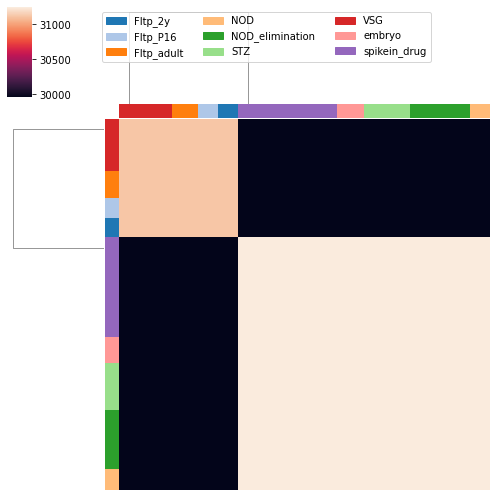

In [21]:
# Plot
sb.clustermap(features_matching.astype('int'),xticklabels=False,yticklabels=False,
             row_colors=studies_colors,col_colors=studies_colors,figsize=(7,7))
plt.legend(handles=patches, bbox_to_anchor=(17, 1),ncol=3)

Also check if all labels match (also take nan,nan as match).

In [75]:
features_all_matching=pd.DataFrame(index=features.columns,columns=features.columns)
for f1 in features.columns:
    for f2 in features.columns:
        # This gives True for 'a','a' but 0 for 'a',nan and nan,nan
        features_all_matching.at[f1,f2]=int(
            (features[f1].fillna('NA')==features[f2].fillna('NA')).all())

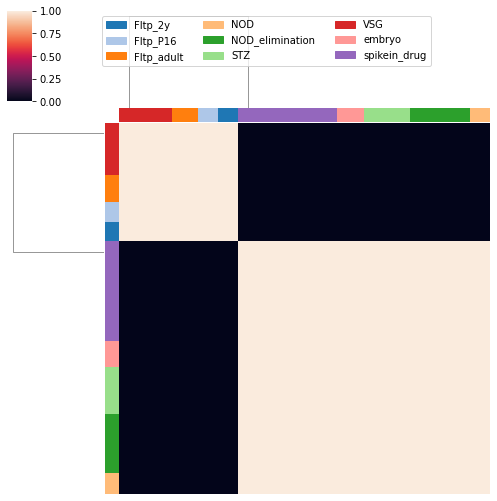

In [76]:
sb.clustermap(features_all_matching.astype('int'),xticklabels=False,yticklabels=False,
             row_colors=studies_colors,col_colors=studies_colors,figsize=(7,7))
plt.legend(handles=patches, bbox_to_anchor=(17, 1),ncol=3)

C: The two dataset cluster occur due to two different genome version used for alignment.

#### How strongly are expressed genes for which EIDs do not match
Calculate per study how strongly are expressed genes with unmatching annotation. This is done per study not sample as annotation is the same across samples of individual study.

In [6]:
data_study=[
      ('Fltp_2y','/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/islets_aged_fltp_iCre/rev6/'),
      ('Fltp_adult','/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/islet_fltp_headtail/rev4/'),
      ('Fltp_P16','/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/salinno_project/rev4/'),
      ('NOD','/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/GSE144471/'),
      ('NOD_elimination','/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/GSE117770/'),
      ('spikein_drug','/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/GSE142465/'),
      ('embryo','/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/GSE132188/rev7/'),
      ('VSG','/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/VSG_PF_WT_cohort/rev7/'),
      ('STZ','/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/islet_glpest_lickert/rev7/')
    ]

How many genes with symbol inconsistency are present in QC-ed data of each study. 

Diff symbol - different symbol across studies. Diff anno - different symbol or gene annotation being present in only some studies' genomes. All genes - all QC-ed genes.

Fltp_2y
N genes with different symbol in filtered adata: 295
N genes with different annotation (symbol+not present in some samples) in filtered adata: 497

Mean across genes:


,n_cells,mean_expr_in_expr_cells
all,4055,2.11398
diff symbol,2965.3,1.49617
diff anno,2074.36,1.3693



Median across genes:


,n_cells,mean_expr_in_expr_cells
all,2228,1.27481
diff symbol,876,1.16066
diff anno,341,1.11309


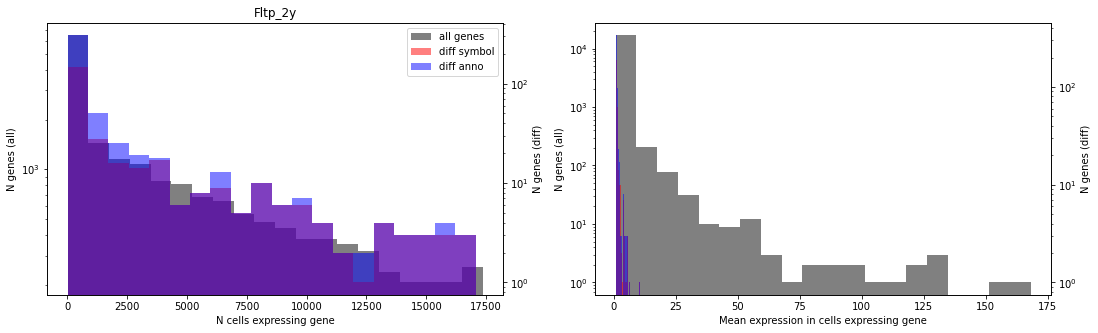

Fltp_adult
N genes with different symbol in filtered adata: 280
N genes with different annotation (symbol+not present in some samples) in filtered adata: 478

Mean across genes:


,n_cells,mean_expr_in_expr_cells
all,3809.8,1.63652
diff symbol,2975.55,1.38745
diff anno,2183.2,1.27794



Median across genes:


,n_cells,mean_expr_in_expr_cells
all,2030,1.16816
diff symbol,876.5,1.09763
diff anno,356,1.06946


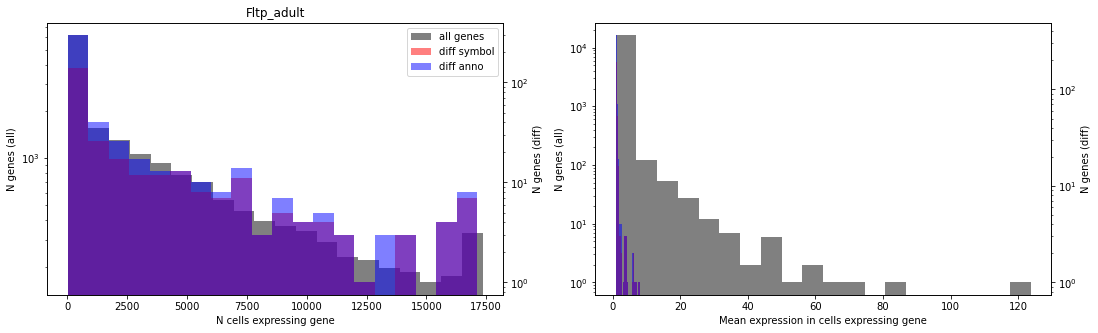

Fltp_P16
N genes with different symbol in filtered adata: 294
N genes with different annotation (symbol+not present in some samples) in filtered adata: 484

Mean across genes:


,n_cells,mean_expr_in_expr_cells
all,3576.9,1.63974
diff symbol,2747.14,1.34048
diff anno,2073.87,1.24949



Median across genes:


,n_cells,mean_expr_in_expr_cells
all,1689,1.1449
diff symbol,654.5,1.09696
diff anno,303,1.07249


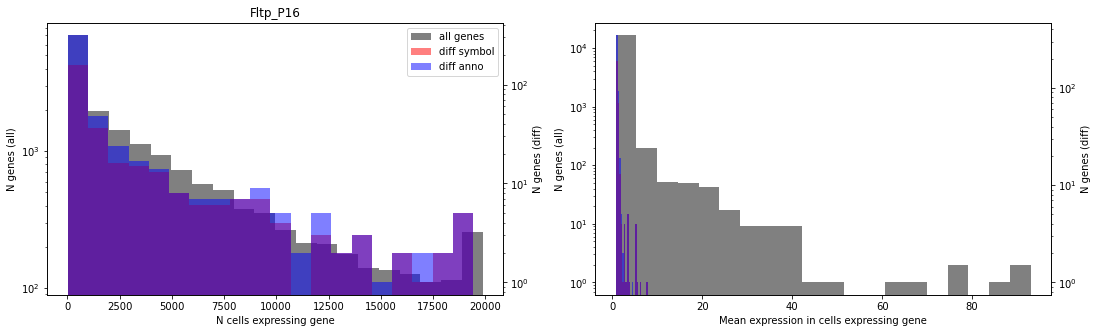

NOD
N genes with different symbol in filtered adata: 239
N genes with different annotation (symbol+not present in some samples) in filtered adata: 327

Mean across genes:


,n_cells,mean_expr_in_expr_cells
all,582.248,1.83385
diff symbol,509.301,1.57692
diff anno,437.596,1.49116



Median across genes:


,n_cells,mean_expr_in_expr_cells
all,347,1.21829
diff symbol,236,1.16335
diff anno,127,1.13899


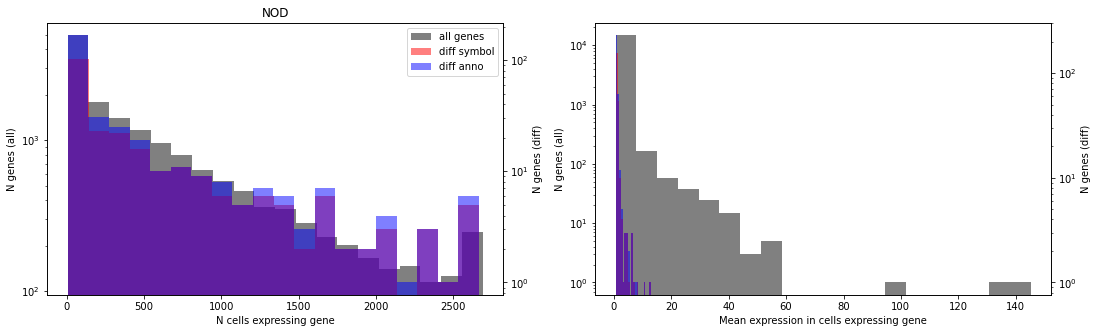

NOD_elimination
N genes with different symbol in filtered adata: 340
N genes with different annotation (symbol+not present in some samples) in filtered adata: 519

Mean across genes:


,n_cells,mean_expr_in_expr_cells
all,5642.8,1.45558
diff symbol,3962.24,1.2205
diff anno,3022.57,1.1868



Median across genes:


,n_cells,mean_expr_in_expr_cells
all,2377,1.14887
diff symbol,657,1.09566
diff anno,306,1.08623


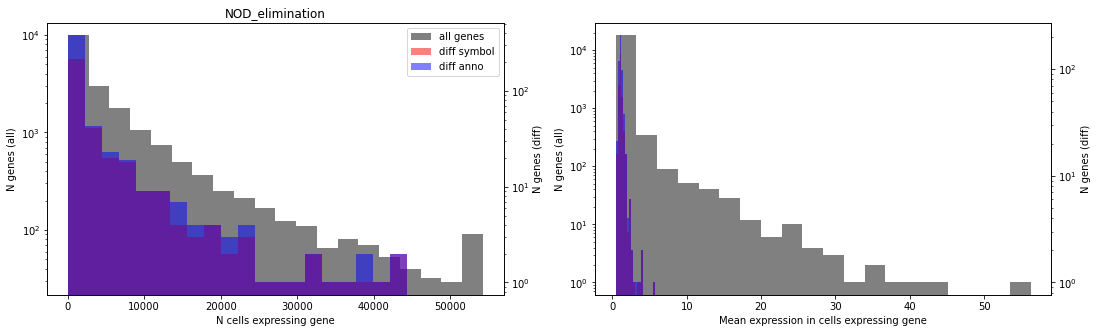

spikein_drug
N genes with different symbol in filtered adata: 316
N genes with different annotation (symbol+not present in some samples) in filtered adata: 473

Mean across genes:


,n_cells,mean_expr_in_expr_cells
all,4906.54,1.88042
diff symbol,3618,1.66341
diff anno,2822.73,1.53926



Median across genes:


,n_cells,mean_expr_in_expr_cells
all,2356,1.25828
diff symbol,702,1.16433
diff anno,328,1.13575


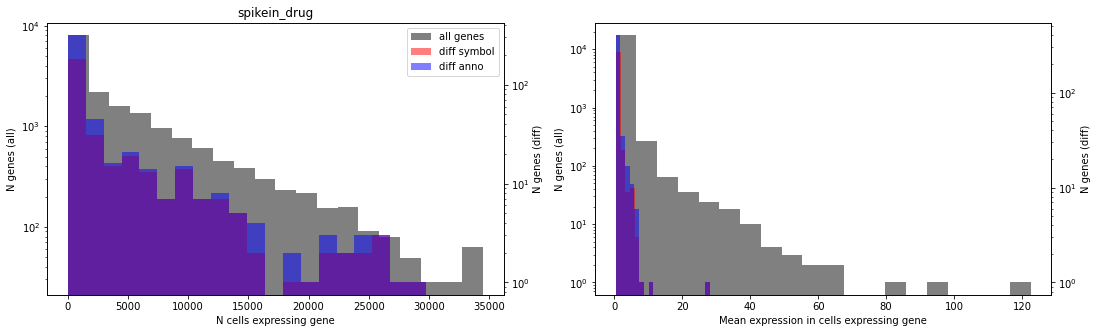

embryo
N genes with different symbol in filtered adata: 319
N genes with different annotation (symbol+not present in some samples) in filtered adata: 463

Mean across genes:


,n_cells,mean_expr_in_expr_cells
all,7599.72,1.89737
diff symbol,5269.47,1.74249
diff anno,4282.92,1.58525



Median across genes:


,n_cells,mean_expr_in_expr_cells
all,3393,1.23869
diff symbol,937,1.13409
diff anno,495,1.13369


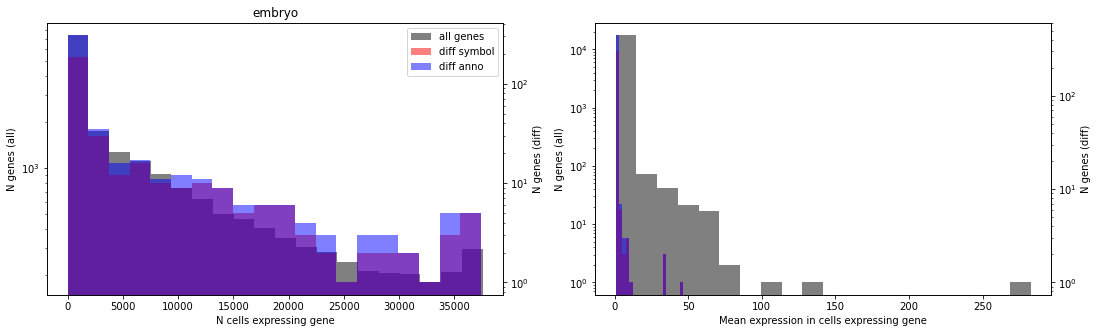

VSG
N genes with different symbol in filtered adata: 373
N genes with different annotation (symbol+not present in some samples) in filtered adata: 668

Mean across genes:


,n_cells,mean_expr_in_expr_cells
all,10882.3,2.71527
diff symbol,7851.76,1.98232
diff anno,5180.47,1.77245



Median across genes:


,n_cells,mean_expr_in_expr_cells
all,4499,1.42802
diff symbol,1145,1.28702
diff anno,465.5,1.25625


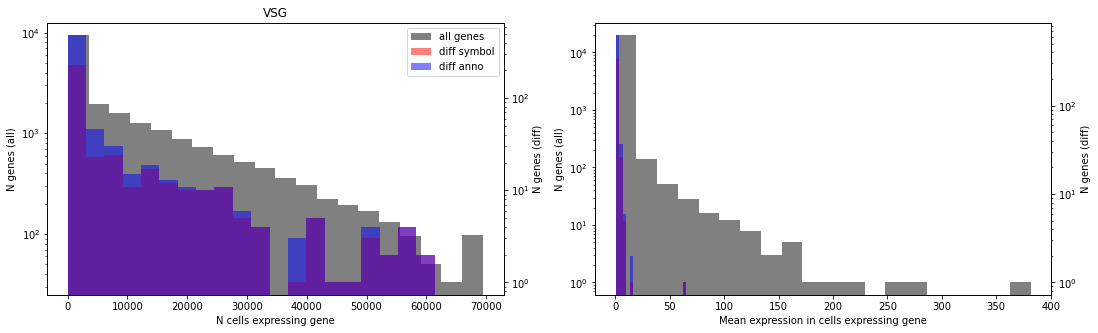

STZ
N genes with different symbol in filtered adata: 322
N genes with different annotation (symbol+not present in some samples) in filtered adata: 476

Mean across genes:


,n_cells,mean_expr_in_expr_cells
all,6476.22,1.86875
diff symbol,4585.34,1.42665
diff anno,3644.59,1.36433



Median across genes:


,n_cells,mean_expr_in_expr_cells
all,2750,1.23282
diff symbol,742.5,1.14198
diff anno,400.5,1.10997


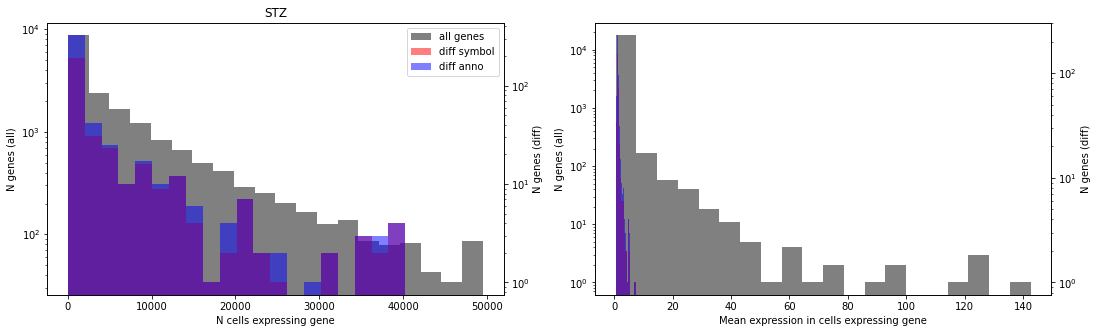

In [31]:
for study,file in data_study:
    # QC-ed data of the study
    print(study)
    adata_study=sc.read(file+'data_normalised.h5ad')
    # Use normalised expresion without log transform
    adata_study.X=np.asarray(
        adata_study.layers['counts']/adata_study.obs.size_factors.values.reshape(-1,1))
    # recompute n cells as this was done before cell filtering
    adata_study.var['n_cells_filtered']=(adata_study.X>0).sum(axis=0)
    adata_study.var['mean_expr_in_expr_cells'
                   ]=adata_study.X.sum(axis=0)/adata_study.var['n_cells_filtered']

    # Prepare EID-symbol mapping to match symbols in adata
    # Symbols from the study
    features_temp=pd.DataFrame(
    features[[col for col in features.columns if col.split('__')[0]==study][0]].copy())
    features_temp.columns=['symbol']
    features_temp['EID']=features_temp.index.values
    features_temp.index=features_temp.symbol.values
    # Keep only genes present in studie's genome
    features_temp=features_temp[~features_temp.index.isna()]
    # Make sure that gene symbols match those in adata
    adata_temp=anndata.AnnData(var=features_temp)
    adata_temp.var_names_make_unique()
    features_temp['symbol_adata']=adata_temp.var_names
    features_temp.index=features_temp['EID']

    # Find out how many genes with symbol name conflicts are in QC-ed data
    diff_symbol_genes=features_temp.loc[different_symbol.keys(),'symbol_adata'].values
    diff_symbol_genes_adata=[gene for gene in diff_symbol_genes if gene in adata_study.var_names]
    print('N genes with different symbol in filtered adata:',len(diff_symbol_genes_adata) )
    diff_anno_genes=features_temp.loc[
        [ gene for gene in different_anno.keys() if gene in features_temp.index],
        'symbol_adata'].values
    diff_anno_genes_adata=[gene for gene in diff_anno_genes if gene in adata_study.var_names]
    print('N genes with different annotation (symbol+not present in some samples) in filtered adata:',
          len(diff_anno_genes_adata) )

    # Summary of mean expr values across genes
    expr_summary=pd.DataFrame(columns=['n_cells','mean_expr_in_expr_cells'],
                              index=['all','diff symbol','diff anno'])
    expr_summary.at['all','n_cells']=adata_study.var.loc[:,'n_cells_filtered'].mean()
    expr_summary.at['all','mean_expr_in_expr_cells'
                   ]=adata_study.var.loc[:,'mean_expr_in_expr_cells'].mean()
    expr_summary.at['diff symbol','n_cells'
                   ]=adata_study.var.loc[diff_symbol_genes_adata,'n_cells_filtered'].mean()
    expr_summary.at['diff symbol','mean_expr_in_expr_cells'
                   ]=adata_study.var.loc[diff_symbol_genes_adata,'mean_expr_in_expr_cells'].mean()
    expr_summary.at['diff anno','n_cells'
                   ]=adata_study.var.loc[diff_anno_genes_adata,'n_cells_filtered'].mean()
    expr_summary.at['diff anno','mean_expr_in_expr_cells'
                   ]=adata_study.var.loc[diff_anno_genes_adata,'mean_expr_in_expr_cells'].mean()
    print('\nMean across genes:')
    display(expr_summary)
    # Summary of median expr values across genes
    expr_summary=pd.DataFrame(columns=['n_cells','mean_expr_in_expr_cells'],
                              index=['all','diff symbol','diff anno'])
    expr_summary.at['all','n_cells']=adata_study.var.loc[:,'n_cells_filtered'].median()
    expr_summary.at['all','mean_expr_in_expr_cells'
                   ]=adata_study.var.loc[:,'mean_expr_in_expr_cells'].median()
    expr_summary.at['diff symbol','n_cells'
                   ]=adata_study.var.loc[diff_symbol_genes_adata,'n_cells_filtered'].median()
    expr_summary.at['diff symbol','mean_expr_in_expr_cells'
                   ]=adata_study.var.loc[diff_symbol_genes_adata,'mean_expr_in_expr_cells'].median()
    expr_summary.at['diff anno','n_cells'
                   ]=adata_study.var.loc[diff_anno_genes_adata,'n_cells_filtered'].median()
    expr_summary.at['diff anno','mean_expr_in_expr_cells'
                   ]=adata_study.var.loc[diff_anno_genes_adata,'mean_expr_in_expr_cells'].median()
    print('\nMedian across genes:')
    display(expr_summary)

    # plot N cells and mean expresion in expr cells per gene 
    # for genes in QC-ed data that have gene symbol conflicts
    fig,ax=plt.subplots(1,2,figsize=(18,5))
    ax[0].hist(adata_study.var.loc[:,'n_cells_filtered'],bins=20,label='all genes',color='grey')
    ax[1].hist(adata_study.var.loc[:,'mean_expr_in_expr_cells'],bins=20,label='all genes',color='grey')
    ax2=ax[0].twinx()
    ax3=ax[1].twinx()
    ax2.hist(adata_study.var.loc[diff_symbol_genes_adata,'n_cells_filtered'],color='red',
            bins=20,label='diff symbol',alpha=0.5)
    ax2.hist(adata_study.var.loc[diff_anno_genes_adata,'n_cells_filtered'],color='blue',
            bins=20,label='diff anno',alpha=0.5)
    ax3.hist(adata_study.var.loc[diff_symbol_genes_adata,'mean_expr_in_expr_cells'],color='red',
            bins=20,label='diff symbol',alpha=0.5)
    ax3.hist(adata_study.var.loc[diff_anno_genes_adata,'mean_expr_in_expr_cells'],color='blue',
            bins=20,label='diff anno',alpha=0.5)
    ax[0].set_title(study)
    ax[0].set_yscale('log')
    ax2.set_yscale('log')
    ax[1].set_yscale('log')
    ax3.set_yscale('log')
    ax[0].set_xlabel('N cells expressing gene')
    ax[1].set_xlabel('Mean expression in cells expressing gene')
    ax[0].set_ylabel('N genes (all)')
    ax2.set_ylabel('N genes (diff)')
    ax[1].set_ylabel('N genes (all)')
    ax3.set_ylabel('N genes (diff)')
    handles, labels = ax[0].get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(handles=handles+handles2)
    display(fig)
    plt.close()
 
del adata_temp
del adata_study
del features_temp

## Add data from Ensembl
Add gene info downloaded from BioMart.

Ensembl data

In [4]:
# Genome info
org='mus_musculus'
if org=='mus_musculus':
    org_short='MM'
anno_v=103

In [5]:
# Get data from https://m.ensembl.org/biomart/martview/
anno_path='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/gene_lists/'
genes_df=[]
curr_cols=set()
for f in Path(anno_path).rglob('mart_export_'+str(anno_v)+org_short+'*.txt'):
    if 'NCBI_ID' not in f.name:
        print(f)
        df=pd.read_table(f,index_col='Gene stable ID')
        print('Drop second duplicated:',df[df.index.duplicated(keep=False)])
        df=df[~df.index.duplicated()]
        df.drop([col for col in df.columns if col in curr_cols],axis=1,inplace=True)
        curr_cols.update(df.columns.values)
        genes_df.append(df)
genes_df=pd.concat(genes_df,axis=1)
genes_df['EID']=genes_df.index

/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/gene_lists/mart_export_103MM_EnsemblData.txt
Drop second duplicated: Empty DataFrame
Columns: [Gene stable ID version, Chromosome/scaffold name, Gene start (bp), Gene end (bp), Strand, Gene name, Gene type]
Index: []
/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/gene_lists/mart_export_103MM_MGI_ID.txt
Drop second duplicated:                    Gene stable ID version Gene name       MGI ID
Gene stable ID                                                  
ENSMUSG00000082414   ENSMUSG00000082414.3   Gm21093  MGI:5434448
ENSMUSG00000082414   ENSMUSG00000082414.3   Gm21093  MGI:3705775
ENSMUSG00000115016   ENSMUSG00000115016.3   Gm33906  MGI:5593065
ENSMUSG00000115016   ENSMUSG00000115016.3   Gm33906  MGI:2145569
/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/gene_lists/mart_export_103MM_MGI_symbol.txt
Drop second duplicated:                    Gene stable ID version MGI symbol
Gene stable ID                 

In [115]:
# Ensembl data
genes_df

,Gene stable ID version,Chromosome/scaffold name,Gene start (bp),Gene end (bp),Strand,Gene name,Gene type,MGI ID,MGI symbol,EID
ENSMUSG00000064336,ENSMUSG00000064336.1,MT,1,68,1,mt-Tf,Mt_tRNA,MGI:102487,mt-Tf,ENSMUSG00000064336
ENSMUSG00000064337,ENSMUSG00000064337.1,MT,70,1024,1,mt-Rnr1,Mt_rRNA,MGI:102493,mt-Rnr1,ENSMUSG00000064337
ENSMUSG00000064338,ENSMUSG00000064338.1,MT,1025,1093,1,mt-Tv,Mt_tRNA,MGI:102472,mt-Tv,ENSMUSG00000064338
ENSMUSG00000064339,ENSMUSG00000064339.1,MT,1094,2675,1,mt-Rnr2,Mt_rRNA,MGI:102492,mt-Rnr2,ENSMUSG00000064339
ENSMUSG00000064340,ENSMUSG00000064340.1,MT,2676,2750,1,mt-Tl1,Mt_tRNA,MGI:102482,mt-Tl1,ENSMUSG00000064340
...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000010505,ENSMUSG00000010505.17,2,181405125,181469590,1,Myt1,protein_coding,MGI:1100535,Myt1,ENSMUSG00000010505
ENSMUSG00000027589,ENSMUSG00000027589.15,2,181479647,181499254,1,Pcmtd2,protein_coding,MGI:1923927,Pcmtd2,ENSMUSG00000027589
ENSMUSG00000038628,ENSMUSG00000038628.9,2,181506130,181512623,1,Polr3k,protein_coding,MGI:1914255,Polr3k,ENSMUSG00000038628
ENSMUSG00000083397,ENSMUSG00000083397.2,2,181538616,181540505,1,Gm5466,processed_pseudogene,MGI:3647828,Gm5466,ENSMUSG00000083397


#### Combined anno from adata and ensebl

In [31]:
missing4=set(features.index.values)-set(genes_df.EID.values)
print('Missing gene EIDs from ensembl annotation:',len(missing4),'/',features.shape[0])
print('N genes not in ensembl anno that are withing genes that have different symbols:',
      len(missing4 & set(different_symbol.keys())))
print('N genes not in ensembl anno that are withing genes that have different presence:',
      len(missing4 & set(different_presence.keys())))
print('N genes not in ensembl anno that are withing genes that have different anno:',
      len(missing4 & set(different_anno.keys())))

Missing gene EIDs from ensembl annotation: 371 / 31706
N genes not in ensembl anno that are withing genes that have different symbols: 10
N genes not in ensembl anno that are withing genes that have different presence: 321
N genes not in ensembl anno that are withing genes that have different anno: 331


In [19]:
genes_df_merged=genes_df.copy()
genes_df_merged.index=genes_df_merged['EID']
genes_df_merged=genes_df_merged.reindex(features.index)
genes_df_merged['EID']=genes_df_merged.index
added_studies=[]
for col in features.columns:
    study=col.split('__')[0]
    if study not in added_studies:
        genes_df_merged['gene_symbol_'+study]=features[col]
        added_studies.append(study)

In [20]:
genes_df_merged

,Gene stable ID version,Chromosome/scaffold name,Gene start (bp),Gene end (bp),Strand,Gene name,Gene type,MGI ID,MGI symbol,EID,gene_symbol_Fltp_2y,gene_symbol_Fltp_P16,gene_symbol_Fltp_adult,gene_symbol_NOD,gene_symbol_NOD_elimination,gene_symbol_STZ,gene_symbol_VSG,gene_symbol_embryo,gene_symbol_spikein_drug
ENSMUSG00000051951,ENSMUSG00000051951.6,1,3276124.0,3741721.0,-1.0,Xkr4,protein_coding,MGI:3528744,Xkr4,ENSMUSG00000051951,Xkr4,Xkr4,Xkr4,Xkr4,Xkr4,Xkr4,Xkr4,Xkr4,Xkr4
ENSMUSG00000089699,ENSMUSG00000089699.2,1,3536810.0,3583776.0,1.0,Gm1992,lncRNA,MGI:3780162,Gm1992,ENSMUSG00000089699,Gm1992,Gm1992,Gm1992,Gm1992,Gm1992,Gm1992,Gm1992,Gm1992,Gm1992
ENSMUSG00000102343,ENSMUSG00000102343.2,1,3975962.0,4056438.0,-1.0,Gm37381,lncRNA,MGI:5610609,Gm37381,ENSMUSG00000102343,Gm37381,Gm37381,Gm37381,Gm37381,Gm37381,Gm37381,Gm37381,Gm37381,Gm37381
ENSMUSG00000025900,ENSMUSG00000025900.14,1,4069780.0,4479464.0,-1.0,Rp1,protein_coding,MGI:1341105,Rp1,ENSMUSG00000025900,Rp1,Rp1,Rp1,Rp1,Rp1,Rp1,Rp1,Rp1,Rp1
ENSMUSG00000025902,ENSMUSG00000025902.14,1,4561154.0,4567577.0,-1.0,Sox17,protein_coding,MGI:107543,Sox17,ENSMUSG00000025902,Sox17,Sox17,Sox17,Sox17,Sox17,Sox17,Sox17,Sox17,Sox17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000117871,ENSMUSG00000117871.2,19,58080246.0,58084463.0,-1.0,Gm50287,lncRNA,MGI:6303125,Gm50287,ENSMUSG00000117871,NaN,NaN,NaN,Gm50287,Gm50287,Gm50287,NaN,Gm50287,Gm50287
ENSMUSG00000118223,ENSMUSG00000118223.2,19,58683953.0,58684609.0,1.0,1810035K13Rik,lncRNA,MGI:1925578,1810035K13Rik,ENSMUSG00000118223,NaN,NaN,NaN,1810035K13Rik,1810035K13Rik,1810035K13Rik,NaN,1810035K13Rik,1810035K13Rik
ENSMUSG00000118031,ENSMUSG00000118031.2,19,59649755.0,59669638.0,1.0,Gm19956,lncRNA,MGI:5012141,Gm19956,ENSMUSG00000118031,NaN,NaN,NaN,Gm19956,Gm19956,Gm19956,NaN,Gm19956,Gm19956
ENSMUSG00000118190,ENSMUSG00000118190.2,19,59679166.0,59679532.0,1.0,Gm50411,lncRNA,MGI:6303327,Gm50411,ENSMUSG00000118190,NaN,NaN,NaN,Gm50411,Gm50411,Gm50411,NaN,Gm50411,Gm50411


In [21]:
genes_df_merged['MGI symbol'].isna().sum()

449

In [36]:
print('Unique EIDs:',genes_df_merged['EID'].nunique(),'/',genes_df_merged.shape[0])
print('Unique symbol:',genes_df_merged['Gene name'].nunique(),'/',
      genes_df_merged['Gene name'].dropna().shape[0])

Unique EIDs: 31706 / 31706
Unique symbol: 31301 / 31335


In [23]:
# Save
if SAVE:
    genes_df_merged.to_csv(
        '/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/gene_lists/genomeAnno_ORG'+\
        org+'_V'+str(anno_v)+'.tsv',
        sep='\t')

## Analyse gene symbols used in integration
This part of the notebook can be run only after creating the integrated adata object (next notebook).

In [32]:
adata_integrated=sc.read(
    '/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/data_integrated_annotated.h5ad',
    backed='r')

In [53]:
# Symbols of genes used in integration
integration_genes=adata_integrated.var_names[adata_integrated.var['used_integration']]

In [50]:
# Symbols of genes with different anno, 
# assure that multiple symbols are not used for the same gene
different_anno_symbols=[key for val in different_anno.values() for key in val.keys() 
                            if key !='NA']

In [58]:
# Overlap between mismatch gene symbols and integration symbols
print('Mismatch anno in integration:',len(set(integration_genes)&set(different_anno_symbols)))

Mismatch anno in integration: 0


In [56]:
# N missmatch symbols in whole data
print('N diff anno symbols:',len(set(different_anno_symbols)),
      'N non-unique diff anno symbols (symbol may repeat across EIDs?):',
      len(different_anno_symbols))

N diff anno symbols: 2428 N non-unique diff anno symbols (symbol may repeat across EIDs?): 2476
